In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
try:
    import pcmdpy_gpu as ppy
except:
    import pcmdpy as ppy
import pandas as pd
%matplotlib inline

In [2]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=ppy.gpu_utils._GPU_ACTIVE)

In [3]:
agemodel = ppy.sfhmodels.NonParam()

tau_model = ppy.sfhmodels.TauModel(iso_step=-1)
tau_model.set_params(np.array([2.258, 2.8205]))

tau_SFH = list(np.log10(tau_model.SFH))

gal_np = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    agemodel,
    ppy.distancemodels.VariableDistance()
)
gal_np.set_params(np.array([0.1676, -1.8033] + tau_SFH + [24.42]))

gal_nomu = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    agemodel,
    ppy.distancemodels.FixedDistance(24.42)
)
gal_nomu.set_params(np.array([0.1676, -1.8033] + tau_SFH))

In [11]:
res = {}
m31_regions = [1, 2]
m31_names = {1: 'Bulge', 2: 'Disk'}
for r in [1, 2]:
    res['m31_{:d}'.format(r)] = ppy.results.ResultsPlotter('results/m31_tau_narrow_r{:d}.csv'.format(r),
                                                        run_name='M31 {:s}'.format(m31_names[r]))
    res['m31_{:d}_nm'.format(r)] = ppy.results.ResultsPlotter('results/m31_taunomu_narrow_r{:d}.csv'.format(r),
                                                        run_name='M31 {:s} (Distance Fixed)'.format(m31_names[r]))


/n/home01/bcook/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [51]:
res['m31_1_nm'].best_model.distance_model.dmod = dmod_m31

In [51]:
res['m31_2_nm'].best_model.distance_model.dmod = dmod_m31

In [12]:
dmod_m31 = 24.42
xmax = np.max([len(r.df) for r in res.values()])
print(xmax)


10459


In [13]:
for k, v in res.items():
    if '_nm' in k:
        v.df['dmod'] = dmod_m31

In [14]:
def plot_sets(run_names, regions=[1,2], chains_only=False, dmod_true=24.42, nonparam=False):
    if chains_only:
        nr = 5
    else:
        nr = 8
    if nonparam:
        nr += 4
    nx = len(run_names)
    fs = (10+5*nx, 3*nr)
    fig, axes = plt.subplots(ncols=len(run_names)*len(regions), nrows=nr, figsize=fs, sharex=True, sharey='row')
    for i, r in enumerate(regions):
        for j, n in enumerate(run_names):
            results = res[n.format(r)]
            plot_axes = axes[:, nx*i + j]
            if '_nm' in n:
                if nonparam:
                    plot_axes = list(plot_axes[:7])+list(plot_axes[8:])
                else:
                    plot_axes = list(plot_axes[:4])
            results.plot_chains(axes=plot_axes, chains_only=chains_only)
    if not nonparam:
        for ax in axes[4]:
            ax.axhline(y=dmod_true, ls='--', color='r')
    plt.tight_layout()
    return fig, axes

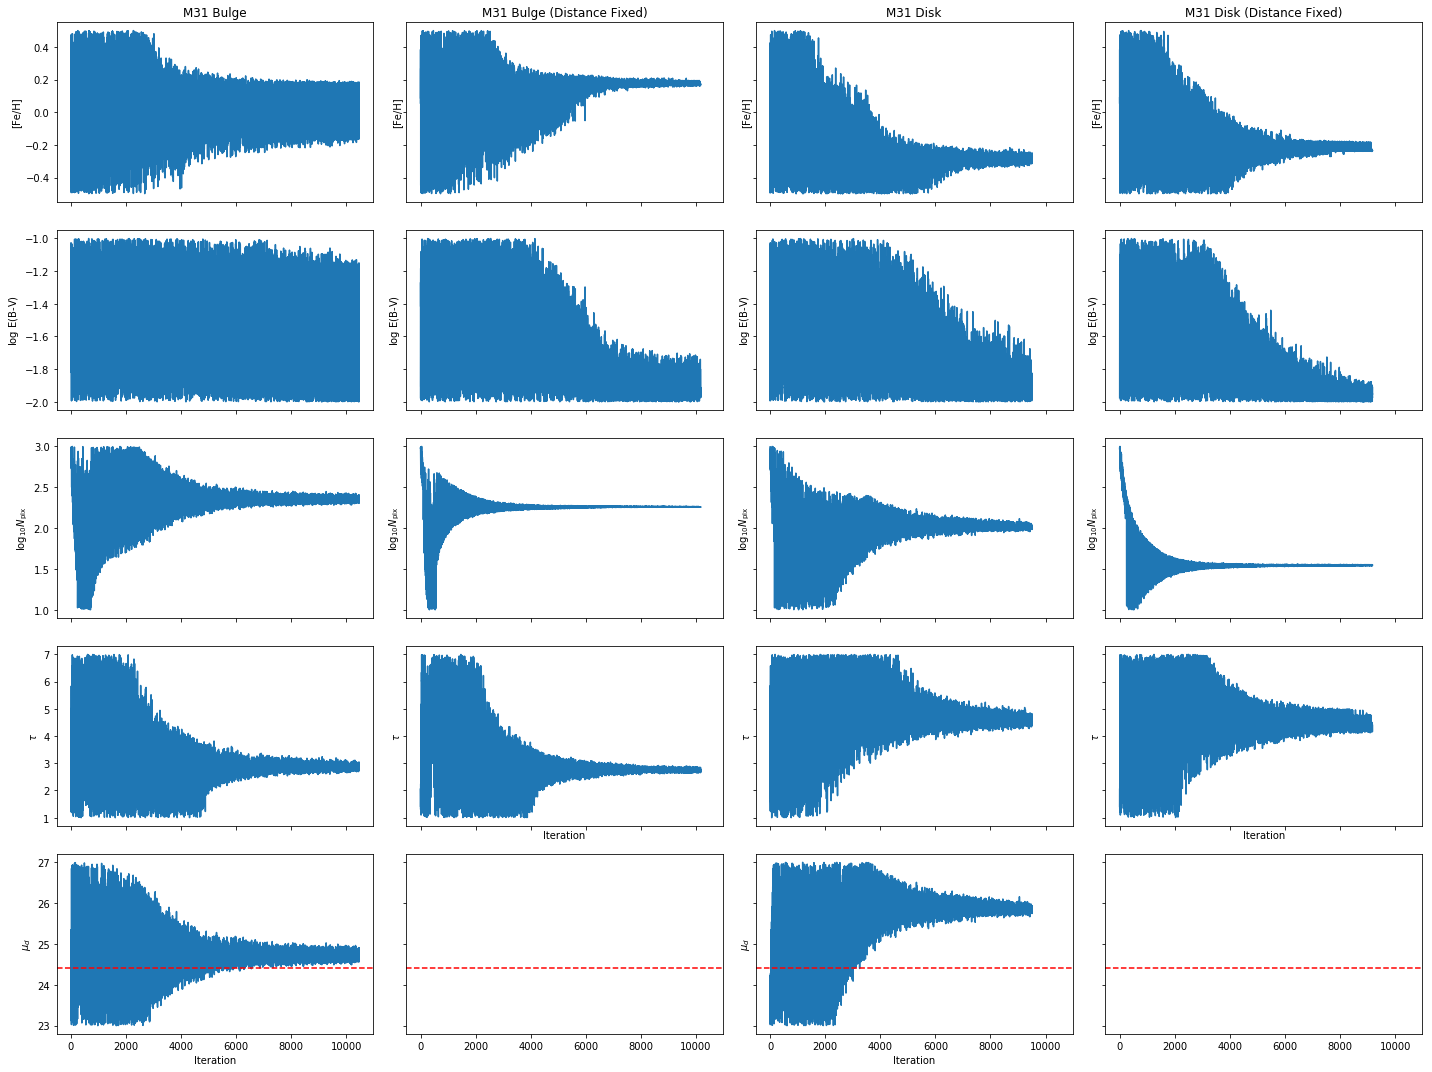

In [16]:
fig, axes = plot_sets(['m31_{:d}', 'm31_{:d}_nm'], chains_only=True)
# plt.savefig('figures/m31_chains_narrowF814W.jpg')

In [9]:
pcmd_bulge = np.loadtxt('../data/m31/pcmds/m31_r1.pcmd', unpack=True)
pcmd_disk = np.loadtxt('../data/m31/pcmds/m31_r2.pcmd', unpack=True)

In [41]:
def plot_resid(model, pcmd_data, Nim=1024, title=None):
    pcmd_model = driv.simulate(model, Nim, mag_system='ab')[0]
    fig, axes = plt.subplots(ncols=3, figsize=(18,5), sharex=True, sharey=True)
    title = '({:s})'.format(title) if title is not None else ''
    _, bins, norm = ppy.plotting.plot_pcmd(pcmd_data, ax=axes[0], title='Data '+title) 
    ppy.plotting.plot_pcmd_residual(pcmd_data, pcmd_model, bins=bins, ax=axes[1])
    _, bins, norm = ppy.plotting.plot_pcmd(pcmd_model, ax=axes[2], bins=bins, title='Model '+title) 
    for a in axes:
        ppy.plotting.plot_isochrone(iso_model, axes=a, dmod=dmod_m31)
    return pcmd_model, axes

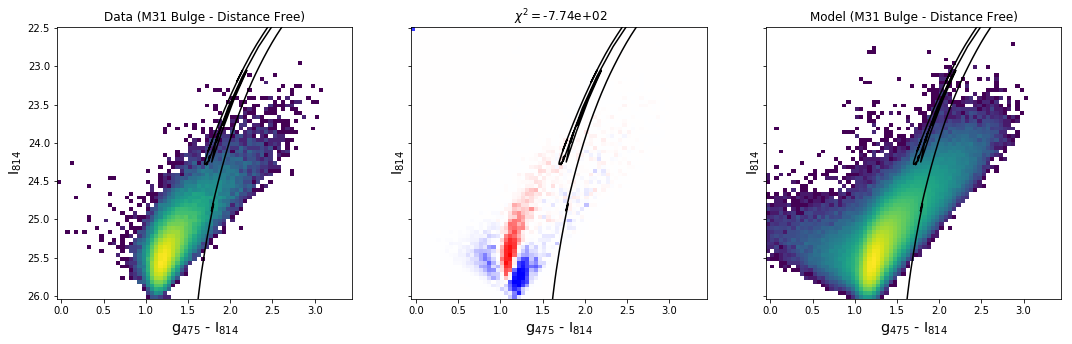

In [42]:
plot_resid(res['m31_1'].best_model, pcmd_bulge, Nim=1024, title='M31 Bulge - Distance Free');

In [52]:
res['m31_2_nm'].best_model.distance_model.dmod = dmod_m31

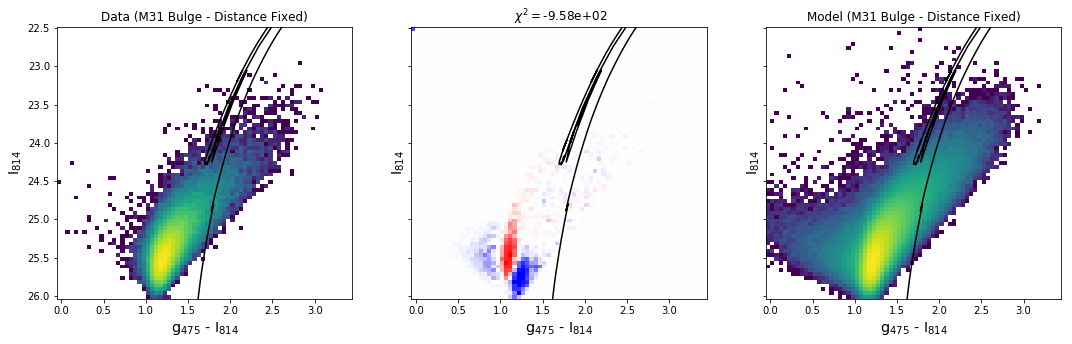

In [53]:
plot_resid(res['m31_1_nm'].best_model, pcmd_bulge, Nim=1024, title='M31 Bulge - Distance Fixed');